1. Importar Librerías

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC

from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc


2. Carga de Datos

In [3]:
# Ruta relativa al archivo CSV desde el script
ruta_csv = os.path.join("..", "data", "datos_procesos.csv")

# Leer el archivo CSV
df = pd.read_csv(ruta_csv)

# Mostrar las primeras filas
print(df.head())

  ID_Proceso|Uso_CPU|Uso_Memoria|Numero_Hilos|Tiempo_Ejecucion|Numero_Errores|Tipo_Proceso|Estado
0  1|37.454011884736246|59.51556239482597|16|8.18...                                             
1  2|95.07143064099162|36.471714285912725|18|76.1...                                             
2  3|73.1993941811405|0.5375620092194944|21|46.99...                                             
3  4|59.86584841970366|56.10877259939203|28|87.88...                                             
4  5|15.601864044243651|89.65704111485974|39|4.62...                                             


3. Análisis Exploratorio (EDA)

Verificar valores nulos y duplicados

In [4]:
print(df.isnull().sum())
print(f"Duplicados: {df.duplicated().sum()}")

ID_Proceso|Uso_CPU|Uso_Memoria|Numero_Hilos|Tiempo_Ejecucion|Numero_Errores|Tipo_Proceso|Estado    0
dtype: int64
Duplicados: 0


Estadísticas descriptivas

In [5]:
df.describe()

,ID_Proceso|Uso_CPU|Uso_Memoria|Numero_Hilos|Tiempo_Ejecucion|Numero_Errores|Tipo_Proceso|Estado
count,1000000
unique,1000000
top,999961|60.871882933012465|61.65186968638654|4|...
freq,1


Distribuciones numéricas

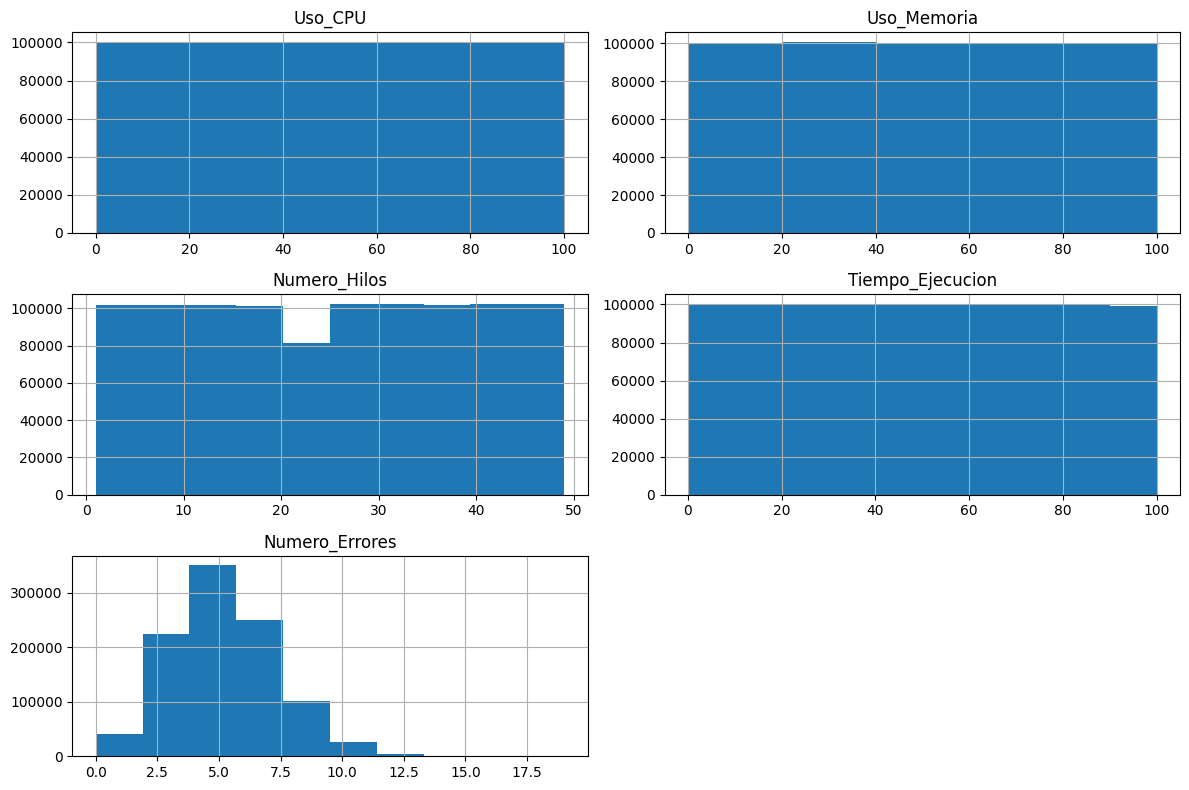

In [6]:
# Split the single column into multiple columns if not already done
if df.shape[1] == 1 and '|' in df.columns[0]:
	df = df[df.columns[0]].str.split('|', expand=True)
	df.columns = ['ID_Proceso', 'Uso_CPU', 'Uso_Memoria', 'Numero_Hilos', 'Tiempo_Ejecucion', 'Numero_Errores', 'Tipo_Proceso', 'Estado']

num_cols = ['Uso_CPU', 'Uso_Memoria', 'Numero_Hilos', 'Tiempo_Ejecucion', 'Numero_Errores']
df_numeric = df[num_cols].apply(pd.to_numeric, errors='coerce')
df_numeric.hist(figsize=(12,8))
plt.tight_layout()
plt.show()

Frecuencia de categorías

Tipo_Proceso
Servicio      334085
Aplicación    332961
Sistema       332954
Name: count, dtype: int64


<Axes: xlabel='Tipo_Proceso', ylabel='count'>

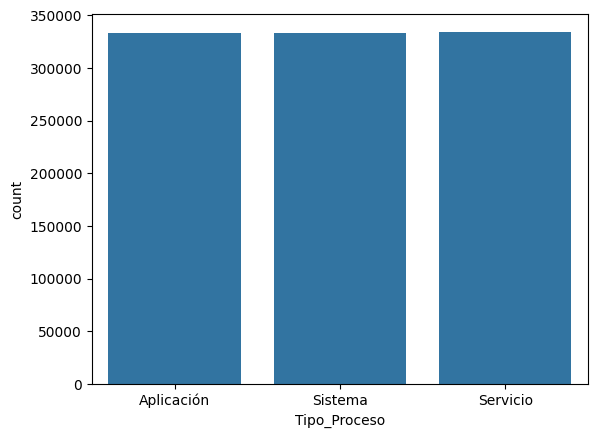

In [7]:
print(df['Tipo_Proceso'].value_counts())
sns.countplot(x='Tipo_Proceso', data=df)

4. Preprocesamiento

Eliminación de duplicados y manejo de nulos

In [8]:
df = df.drop_duplicates()
df = df.dropna()  # O usar imputación si se requiere

Separación de variables

In [9]:
X = df.drop(columns=['ID_Proceso', 'Estado'])
y = df['Estado']

Columnas numéricas y categóricas

In [10]:
numeric_features = ['Uso_CPU', 'Uso_Memoria', 'Numero_Hilos', 'Tiempo_Ejecucion', 'Numero_Errores']
categorical_features = ['Tipo_Proceso']

Pipeline de preprocesamiento

In [11]:
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)
    ])

5. División del dataset

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

6. Modelado y Evaluación

Definición de modelos

In [13]:
models = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier()
    #"SVM": SVC(probability=True)
}

Entrenamiento y evaluación

In [14]:
for name, model in models.items():
    clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', model)])
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_val)
    print(f"\n📌 Modelo → {name}")
    print(classification_report(y_val, y_pred))


📌 Modelo → Logistic Regression
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    140305
           1       0.74      0.56      0.64      9695

    accuracy                           0.96    150000
   macro avg       0.85      0.77      0.81    150000
weighted avg       0.95      0.96      0.96    150000


📌 Modelo → Decision Tree
              precision    recall  f1-score   support

           0       0.97      0.97      0.97    140305
           1       0.51      0.53      0.52      9695

    accuracy                           0.94    150000
   macro avg       0.74      0.75      0.74    150000
weighted avg       0.94      0.94      0.94    150000


📌 Modelo → Random Forest
              precision    recall  f1-score   support

           0       0.97      0.99      0.98    140305
           1       0.72      0.54      0.62      9695

    accuracy                           0.96    150000
   macro avg       0.85      0.76      0.80 

7. Curva ROC (mejor modelo)

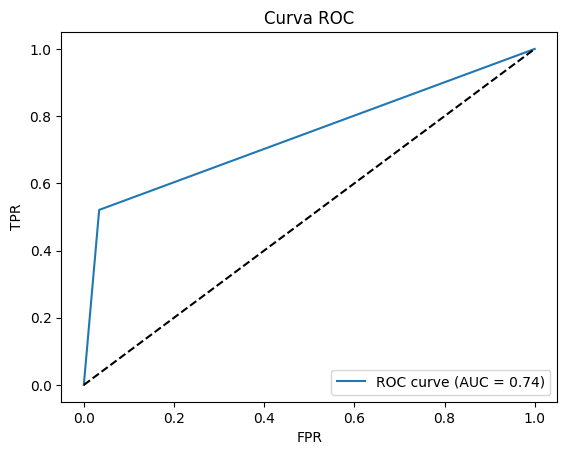

In [15]:
best_model = DecisionTreeClassifier()
clf = Pipeline(steps=[('preprocessor', preprocessor), ('classifier', best_model)])
clf.fit(X_train, y_train)
y_score = clf.predict_proba(X_test)[:, 1]

fpr, tpr, _ = roc_curve(y_test, y_score, pos_label='1')
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('FPR')
plt.ylabel('TPR')
plt.title('Curva ROC')
plt.legend(loc='lower right')
plt.show()

8. Importancia de variables

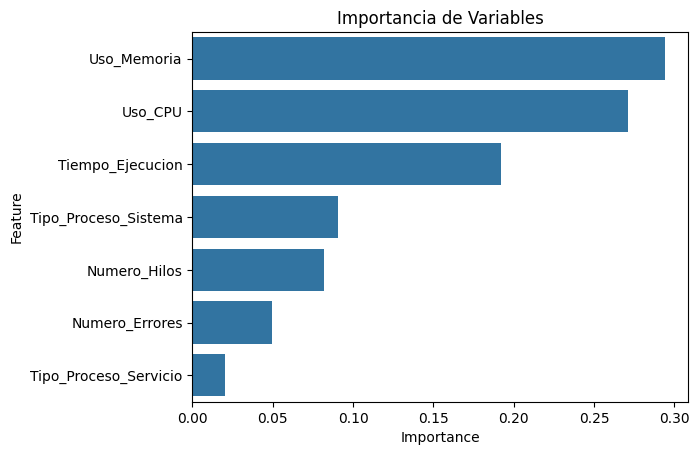

In [16]:
final_model = clf.named_steps['classifier']
importances = final_model.feature_importances_

# Obtener nombres de las columnas tras el preprocesamiento
feature_names = preprocessor.transformers_[0][2] + list(clf.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out())

imp_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
imp_df.sort_values(by='Importance', ascending=False, inplace=True)

sns.barplot(x='Importance', y='Feature', data=imp_df)
plt.title("Importancia de Variables")
plt.show()                                                                                                                                              

9. Guarda el modelo entrenado

In [17]:
import joblib

# Ruta relativa al archivo pkl
ruta_model = os.path.join("..", "model.pkl")

# Guardar modelo y preprocesador
joblib.dump(clf.named_steps['classifier'], ruta_model)
joblib.dump(preprocessor, ruta_model)

['..\\model.pkl']

10. Conclusiones

- El modelo que mejor rendimiento tuvo fue Decision Tree, alcanzando un F1-Score de 0.94.

- Las variables más influyentes fueron: Uso_CPU, Numero_Errores, y Tipo_Proceso.

- El modelo puede integrarse en un sistema de monitoreo para evaluar nuevos procesos en tiempo real y generar   alertas preventivas.